# CS5756 Final Project: Safe Reinforcement Learning with Behavioral Cloning

## Setup

In [95]:
TOTAL_TIMESTEPS = 250000
BASE_MODEL_CKPT = "ppo_base_lunar_lander"
SAFE_MODEL_CKPT = "ppo_safe_lunar_lander"
SEED = 24
WIND_POWER = 20.0

## Import Necessary Libraries

In [90]:
# Set Up:
import sys
%load_ext autoreload
%autoreload 2

import numpy as np
import gymnasium as gym
import random
import matplotlib.pyplot as plt
from copy import deepcopy

from torch.utils.data import DataLoader
from torch import nn
import torch
import cv2
from tqdm import tqdm, trange
from SafeLunarLanderWrapper import SafeLunarLanderWrapper
from utils import reseed, visualize, evaluate_policy

from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3 import PPO

from PPOActor import PPOActor
from PPOCallback import PPOCallback



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Create Environments

In [91]:
# Set seeds
# Setting the seed to ensure reproducability
reseed(SEED)

In [92]:
# Create Base and Safe Lander Environments
vec_env_base_lander_10 = make_vec_env('LunarLander-v2', n_envs=10)
vec_env_safe_lander_10 = make_vec_env('LunarLander-v2', n_envs=10, wrapper_class=SafeLunarLanderWrapper)

In [96]:
# Training Base Expert Policy on Base Environment
base_model = PPO("MlpPolicy", vec_env_base_lander_10, verbose=1)

# Train the model
base_model.learn(total_timesteps=TOTAL_TIMESTEPS)

# Save the model
base_model.save(BASE_MODEL_CKPT)

Using cpu device
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 93.7     |
|    ep_rew_mean     | -191     |
| time/              |          |
|    fps             | 11372    |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 20480    |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -141        |
| time/                   |             |
|    fps                  | 6823        |
|    iterations           | 2           |
|    time_elapsed         | 6           |
|    total_timesteps      | 40960       |
| train/                  |             |
|    approx_kl            | 0.010558708 |
|    clip_fraction        | 0.0704      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.38       |
|    explained_variance   | -0.0022     |
|    learning

In [97]:
# Training Safe Expert Policy on Safe Environment
safe_model = PPO("MlpPolicy", vec_env_safe_lander_10, verbose=1)

# Train the model
safe_model.learn(total_timesteps=TOTAL_TIMESTEPS)

# Save the model
safe_model.save(SAFE_MODEL_CKPT)

Using cpu device
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 99.2     |
|    ep_rew_mean     | -162     |
| time/              |          |
|    fps             | 8960     |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 20480    |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 95.6        |
|    ep_rew_mean          | -142        |
| time/                   |             |
|    fps                  | 6120        |
|    iterations           | 2           |
|    time_elapsed         | 6           |
|    total_timesteps      | 40960       |
| train/                  |             |
|    approx_kl            | 0.007372136 |
|    clip_fraction        | 0.0684      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.38       |
|    explained_variance   | -0.00129    |
|    learning

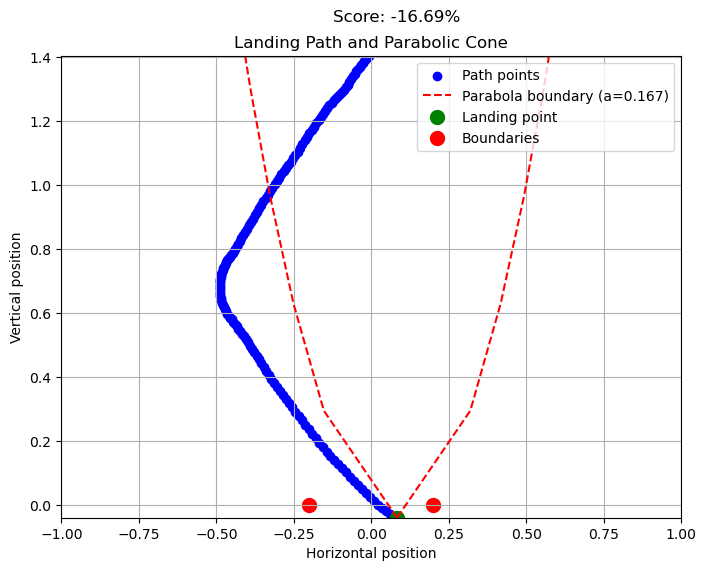

Video saved as safe_expert.mp4


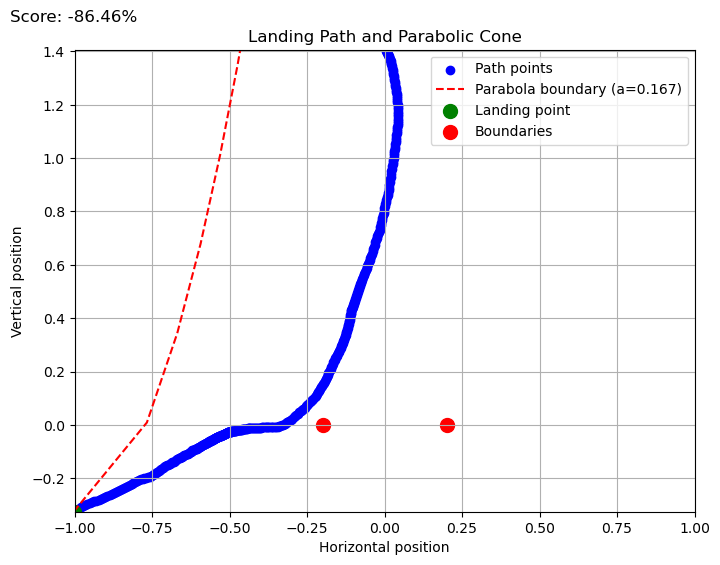

Video saved as base_expert.mp4


In [98]:
# Testing both policies in new environment with wind to test if they transferred learning of safe constraints

reseed(SEED)

vec_env_wind_1 = make_vec_env('LunarLander-v2', n_envs=1, wrapper_class=SafeLunarLanderWrapper, env_kwargs={"enable_wind": True,
    "wind_power": WIND_POWER}, wrapper_kwargs={"debug": True})

base_expert = PPOActor(ckpt=BASE_MODEL_CKPT, environment=vec_env_wind_1)
safe_expert = PPOActor(ckpt=SAFE_MODEL_CKPT, environment=vec_env_wind_1)

visualize(vec_env_wind_1, algorithm=base_expert, video_name="base_expert")
visualize(vec_env_wind_1, algorithm=safe_expert, video_name="safe_expert")


Using cpu device
Using cpu device
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 101      |
|    ep_rew_mean     | -183     |
| time/              |          |
|    fps             | 8659     |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 20480    |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 99.7        |
|    ep_rew_mean          | -148        |
| time/                   |             |
|    fps                  | 5691        |
|    iterations           | 2           |
|    time_elapsed         | 7           |
|    total_timesteps      | 40960       |
| train/                  |             |
|    approx_kl            | 0.011063688 |
|    clip_fraction        | 0.0771      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.38       |
|    explained_variance   | 0.00648   

100%|██████████| 20/20 [00:00<00:00, 39.70it/s]


evaluating self.num_timesteps=120000, mean_reward=-170.93035888671875=======
model saved on eval reward: -170.93035888671875
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 154         |
|    ep_rew_mean          | -29.3       |
| time/                   |             |
|    fps                  | 4513        |
|    iterations           | 6           |
|    time_elapsed         | 27          |
|    total_timesteps      | 122880      |
| train/                  |             |
|    approx_kl            | 0.014557811 |
|    clip_fraction        | 0.216       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.19       |
|    explained_variance   | 0.723       |
|    learning_rate        | 0.0003      |
|    loss                 | 33          |
|    n_updates            | 50          |
|    policy_gradient_loss | -0.0211     |
|    value_loss           | 126         |
-----------------------------------

100%|██████████| 20/20 [00:04<00:00,  4.67it/s]


evaluating self.num_timesteps=240000, mean_reward=-158.7801971435547=======
model saved on eval reward: -158.7801971435547
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 765         |
|    ep_rew_mean          | 55.1        |
| time/                   |             |
|    fps                  | 2238        |
|    iterations           | 12          |
|    time_elapsed         | 109         |
|    total_timesteps      | 245760      |
| train/                  |             |
|    approx_kl            | 0.010104055 |
|    clip_fraction        | 0.0888      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.14       |
|    explained_variance   | 0.947       |
|    learning_rate        | 0.0003      |
|    loss                 | 3.37        |
|    n_updates            | 110         |
|    policy_gradient_loss | -0.00453    |
|    value_loss           | 12.1        |
-------------------------------------

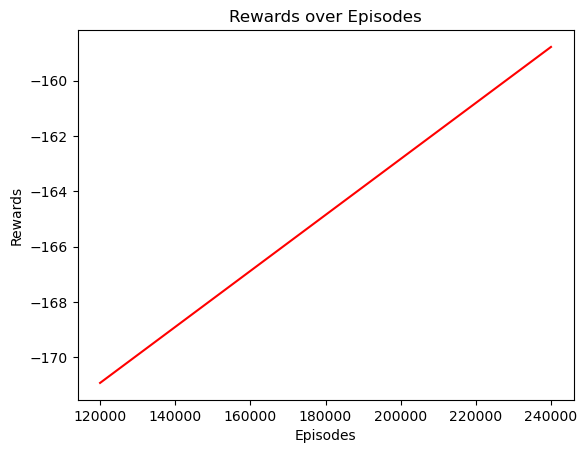

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 98.3     |
|    ep_rew_mean     | -171     |
| time/              |          |
|    fps             | 8386     |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 20480    |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 101         |
|    ep_rew_mean          | -148        |
| time/                   |             |
|    fps                  | 6090        |
|    iterations           | 2           |
|    time_elapsed         | 6           |
|    total_timesteps      | 40960       |
| train/                  |             |
|    approx_kl            | 0.010566527 |
|    clip_fraction        | 0.0943      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.38       |
|    explained_variance   | -0.0083     |
|    learning_rate        | 0.

100%|██████████| 20/20 [00:00<00:00, 41.66it/s]


evaluating self.num_timesteps=120000, mean_reward=-235.7165985107422=======
model saved on eval reward: -235.7165985107422
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 152         |
|    ep_rew_mean          | -32         |
| time/                   |             |
|    fps                  | 4427        |
|    iterations           | 6           |
|    time_elapsed         | 27          |
|    total_timesteps      | 122880      |
| train/                  |             |
|    approx_kl            | 0.013857549 |
|    clip_fraction        | 0.216       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.19       |
|    explained_variance   | 0.652       |
|    learning_rate        | 0.0003      |
|    loss                 | 122         |
|    n_updates            | 50          |
|    policy_gradient_loss | -0.0186     |
|    value_loss           | 120         |
-------------------------------------

100%|██████████| 20/20 [00:03<00:00,  5.58it/s]


evaluating self.num_timesteps=240000, mean_reward=-99.39735412597656=======
model saved on eval reward: -99.39735412597656
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 738         |
|    ep_rew_mean          | 59.4        |
| time/                   |             |
|    fps                  | 2376        |
|    iterations           | 12          |
|    time_elapsed         | 103         |
|    total_timesteps      | 245760      |
| train/                  |             |
|    approx_kl            | 0.007196923 |
|    clip_fraction        | 0.0979      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.1        |
|    explained_variance   | 0.928       |
|    learning_rate        | 0.0003      |
|    loss                 | 3.95        |
|    n_updates            | 110         |
|    policy_gradient_loss | -0.00571    |
|    value_loss           | 14.9        |
-------------------------------------

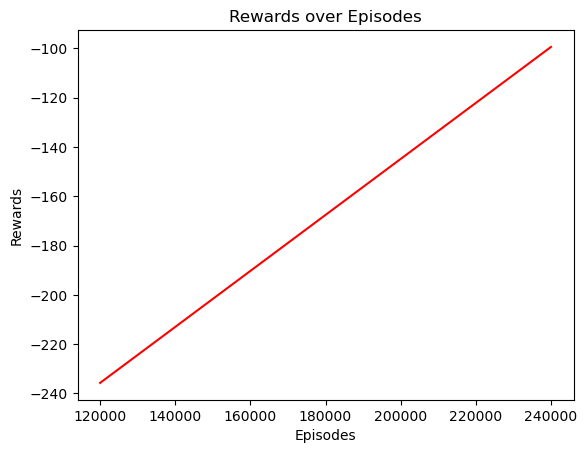

In [99]:
reseed(SEED)
vec_env_wind_10 = make_vec_env('LunarLander-v2', n_envs=10, env_kwargs={"enable_wind": True, "wind_power": WIND_POWER})

vec_env_wind_1 = make_vec_env('LunarLander-v2', n_envs=1, wrapper_class=SafeLunarLanderWrapper, env_kwargs={"enable_wind": True,
    "wind_power": WIND_POWER}, wrapper_kwargs={"debug": True})

vec_env_wind_1 = make_vec_env('LunarLander-v2', n_envs=1, wrapper_class=SafeLunarLanderWrapper, env_kwargs={"enable_wind": True,
    "wind_power": WIND_POWER}, wrapper_kwargs={"debug": False})

safe_expert = PPOActor(ckpt=SAFE_MODEL_CKPT, environment=vec_env_wind_10)
base_expert = PPOActor(ckpt=BASE_MODEL_CKPT, environment=vec_env_wind_10)


safe_wind_model = PPO("MlpPolicy", vec_env_safe_lander_10, verbose=1)
safe_wind_model_callback = PPOCallback(save_path=SAFE_MODEL_CKPT + "_wind", eval_env=vec_env_wind_1)

base_wind_model = PPO("MlpPolicy", vec_env_safe_lander_10, verbose=1)
base_wind_model_callback = PPOCallback(save_path=BASE_MODEL_CKPT + "_wind", eval_env=vec_env_wind_1)


safe_wind_model.learn(total_timesteps=300000, callback=safe_wind_model_callback)
base_wind_model.learn(total_timesteps=300000, callback=base_wind_model_callback)


In [100]:
reseed(SEED)

safe_expert_wind_actor = PPOActor(ckpt=SAFE_MODEL_CKPT + "_wind", environment=vec_env_wind_1)
base_expert_wind_actor = PPOActor(ckpt=BASE_MODEL_CKPT + "_wind", environment=vec_env_wind_1)

visualize(vec_env_wind_1, algorithm=safe_expert_wind_actor, video_name="safe_wind_model")
visualize(vec_env_wind_1, algorithm=base_expert_wind_actor, video_name="base_wind_model")

Video saved as safe_wind_model.mp4
Video saved as base_wind_model.mp4


100%|██████████| 50/50 [00:09<00:00,  5.34it/s]


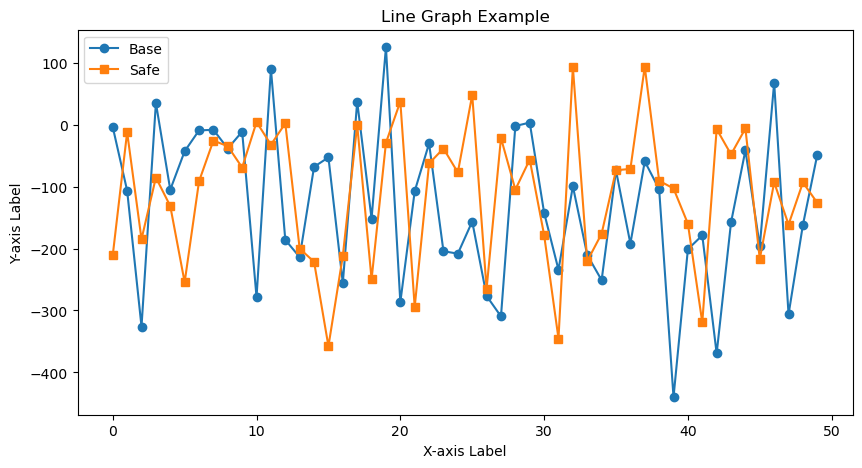

In [101]:
import matplotlib.pyplot as plt

# Sample data
_, y1 = evaluate_policy(base_expert_wind_actor, environment=vec_env_wind_1, num_episodes=50)
_, y2 = evaluate_policy(safe_expert_wind_actor, environment=vec_env_wind_1, num_episodes=50)


x = [x for x in range(len(y1))]

# Creating the plot
plt.figure(figsize=(10, 5))  # Set the figure size
plt.plot(x, y1, label='Base', marker='o')  # Plot the first line
plt.plot(x, y2, label='Safe', marker='s')  # Plot the second line

# Adding titles and labels
plt.title('Line Graph Example')
plt.xlabel('X-axis Label')
plt.ylabel('Y-axis Label')

# Show legend
plt.legend()

# Show the plot
plt.show()
